In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import linear_regression_game
import costsfunctions as cost
import numbers

# Definition of polynomial regression game and optimal design

In [3]:
class Poly_game:
    def __init__(self, x_list, degree, probas, costs, args, number_agents=None):
        """
        Initialize a game with polynomial regression
        - x_list = features of players.
        - degree the degree of the polynomial regression
        - proba = probability of each feature
        - exponents = double or array of double (= exponent of monomial costs)
        By default, we add non-strategic players that span the whole state. 
        """
        self.number_of_features = len(x_list)
        self.number_of_players = len(costs)
        self.dimension = degree + 1
        assert len(x_list) == len(probas), "Error: 'x_list' and 'proba' should be of same length"
        X = [[x**i for i in range(degree + 1)] for x in x_list]
        for x in X:
            assert len(x) == self.dimension, "Error: some features have a wrong dimension"
        self.X = np.array(X)
        self.probas = np.array(probas)
        self.costs = costs
        self.args = args
        self.number_agents = number_agents


    def precision_game(self, scalarization):
        precisions = linear_regression_game.covariance_equilibrium(self.X, self.probas,
                                              scalarization, self.costs, self.args, self.number_agents)
        return precisions.reshape((self.number_of_players, self.number_of_features))


    def scalarization_value(self, precisions, scalarization):
        precisions = precisions.flatten()
        var = linear_regression_game.var(precisions, self.X, self.probas, self.number_agents)
        return scalarization(var, self.X, self.probas)


class Design_prob:
    def __init__(self, x_list, degree, probas):
        """
        Initialize an optimal design problem
        - x_list = features of players.
        - degree the degree of the polynomial regression
        - proba = probability of each feature (relevant for the scalarization)
        """
        self.number_of_features = len(x_list)
        self.dimension = degree + 1
        assert len(x_list) == len(probas), "Error: 'x_list' and 'proba' should be of same length"
        X = [[x**i for i in range(degree + 1)] for x in x_list]
        for x in X:
            assert len(x) == self.dimension, "Error: some features have a wrong dimension"
        self.X = np.array(X)
        self.probas = np.array(probas)
    
    def optimal_design(self, scalarization):
        design = linear_regression_game.optimal_design(self.X, self.probas, scalarization)
        return design

# Probability distributions and plots

In [4]:
x_list = np.array([1])


def unif(xmin=-1000, xmax=1000, epsilon=1e-6):
    p = (x_list >= xmin) * (x_list <= xmax) + epsilon
    return p/sum(p)


def plot_bounds_estim(pmin, pmax, n_list, deg, ratio_agent_1, ratio_agent_2):
    estim_list = []
    estim_list_new = []
    alpha_thm = -(pmin - 1) / (pmin + 1) - ((pmax - pmin)*2/(pmax*(1 + pmin)))
    alpha_max= -(pmax - 1 ) / (pmax + 1)
    alpha_min = -(pmin - 1)/(pmin + 1)
    costs1 = [cost.monomial_cost for i in range(2)]
    costs2 = [cost.monomial_cost]
    for n in n_list:
        distrib = unif()
        g = Poly_game(x_list, deg, distrib, costs1, [pmin, pmax], [ratio_agent_1*n, ratio_agent_2*n])
        precision = g.precision_game(cost.trace_scalarization)
        value = g.scalarization_value(precision, cost.trace_scalarization)
        estim_list.append(value)

    estim_list = np.asarray(estim_list)
    plt.figure()
    plt.xlabel(r"$n$", fontsize=17)
    plt.loglog(n_list, estim_list, label=r'$C_{\mathrm{estim}}(\lambda^*)$')
    list_thm = np.asarray([n**alpha_thm  for n in n_list])
    list_thm = list_thm*estim_list[0]/list_thm[0]
    list_min = np.asarray([n**alpha_min  for n in n_list])
    list_min = list_min*estim_list[0]/list_min[0]
    list_max = np.asarray([n**alpha_max  for n in n_list])
    list_max = list_max*estim_list[0]/list_max[0]
    plt.loglog(n_list, list_thm, label='lower bound')
    plt.loglog(n_list, list_min, label='upper bound')
    plt.loglog(n_list, list_max, label=r'$n^{-q(p_\max - 1)/(p_\max + q)}$')
    plt.legend(prop={'size': 14})
    plt.tight_layout()
    plt.savefig('../figures_paper/fig_comparison_log'+'_'+str(pmin)+'_'+str(pmax))

    
def plot_bounds_estim_polynom(coefs, n_list, deg, pmin, pmax):
    estim_list = []
    estim_list_new = []
    alpha_thm = -(pmin - 1) / (pmin + 1) - ((pmax - pmin)*2/(pmax*(1 + pmin)))
    alpha_max = -(pmax - 1 ) / (pmax + 1)
    alpha_min = -(pmin - 1)/(pmin + 1)
    for n in n_list:
        distrib = unif()
        g = Poly_game(x_list, deg, distrib, [cost.polynomial_cost], [coefs], [n])
        precision = g.precision_game(cost.trace_scalarization)
        value = g.scalarization_value(precision, cost.trace_scalarization)
        estim_list.append(value)

    estim_list = np.asarray(estim_list)
    plt.figure()
    plt.xlabel(r"$n$", fontsize=17)
    plt.loglog(n_list, estim_list, label=r'$C_{\mathrm{estim}}(\lambda^*)$')
    list_thm = np.asarray([n**alpha_thm  for n in n_list])
    list_thm = list_thm*estim_list[0]/list_thm[0]
    list_min = np.asarray([n**alpha_min  for n in n_list])
    list_min = list_min*estim_list[0]/list_min[0]
    list_max = np.asarray([n**alpha_max  for n in n_list])
    list_max = list_max*estim_list[0]/list_max[0]
    plt.loglog(n_list, list_thm, label='lower bound')
    plt.loglog(n_list, list_min, label='upper bound')
    plt.loglog(n_list, list_max, label=r'$n^{-q(p_\max - 1)/(p_\max + q)}$')
    plt.legend(prop={'size': 14})
    plt.tight_layout()
    plt.savefig('../figures_paper/fig_comparison_intended_poly_log'+'_'+str(pmin)+'_'+str(pmax))
    

def plot_bounds_estim_cosh(n_list, deg):
    pmin = 2
    estim_list = []
    alpha_thm = -1.0
    alpha_max = -1.0
    alpha_min = -(pmin - 1)/(pmin + 1)
    for n in n_list:
        distrib = unif()
        g = Poly_game(x_list, deg, distrib, [cost.cosh], [[]], [n])
        precision = g.precision_game(cost.trace_scalarization)
        value = g.scalarization_value(precision, cost.trace_scalarization)
        estim_list.append(value)

    estim_list = np.asarray(estim_list)
    plt.figure()
    plt.xlabel(r"$n$", fontsize=17)
    plt.loglog(n_list, estim_list, label=r'$C_{\mathrm{estim}}(\lambda^*)$')
    list_thm = np.asarray([n**alpha_thm  for n in n_list])
    list_thm = list_thm*estim_list[0]/list_thm[0]
    list_min = np.asarray([n**alpha_min  for n in n_list])
    list_min = list_min*estim_list[0]/list_min[0]
    list_max = np.asarray([n**alpha_max  for n in n_list])
    list_max = list_max*estim_list[0]/list_max[0]
    plt.loglog(n_list, list_thm, label='lower bound')
    plt.loglog(n_list, list_min, label='upper bound', linestyle=(0, (1, 10)), linewidth=6)
    plt.loglog(n_list, list_max, label=r'$n^{-q(p_\max - 1)/(p_\max + q)}$', linestyle=(0, (1, 10)), linewidth=6)
    plt.legend(prop={'size': 14})
    plt.tight_layout()
    plt.savefig('../figures_paper/fig_comparison_intended_cosh_log')

# Heterogeneous agents (Figure 6)

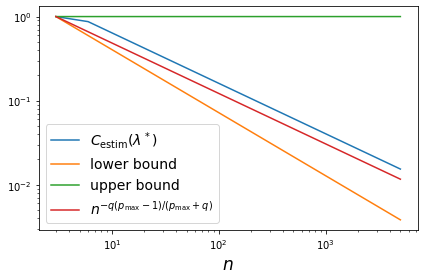

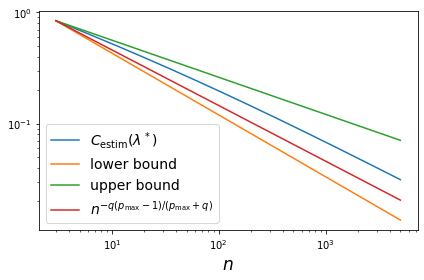

In [4]:
ratio_agent_1 = 2/3
ratio_agent_2 = 1/3
deg = 0
n_list = np.asarray(range(3, 5000, 3))
pmin = 1
pmax = 4
plot_bounds_estim(pmin, pmax, n_list, deg, ratio_agent_1, ratio_agent_2)

pmin = 2
pmax = 3
plot_bounds_estim(pmin, pmax, n_list, deg, ratio_agent_1, ratio_agent_2)

# Agents with polynomial costs (Figure 7)

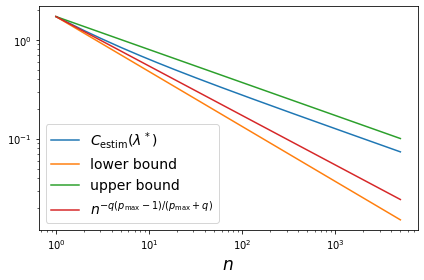

In [5]:
deg = 0
n_list = np.asarray(range(1, 5000))
coefs = [0] + [1 for i in range(4)]
pmin = 1
pmax = 4
plot_bounds_estim_polynom(coefs, n_list, deg, pmin, pmax)

coefs = [0 for i in range(2)] + [1 for i in range(3)]
pmin = 2
pmax = 3
plot_bounds_estim_polynom(coefs, n_list, deg, pmin, pmax)

# Agents with hyperbolic cosinus costs (Figure 8)

In [5]:
deg = 0
n_list = np.asarray(range(1, 5000))
plot_bounds_estim_cosh(n_list, deg)